In [34]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import minimize_scalar

data = pd.read_csv('Natixis stock.txt', delimiter="\t", header=None)
data = data.rename(columns={0: "date", 1: "stock_value"})
data['date'] = pd.to_datetime(data['date'])
data["stock_value"] = data["stock_value"].str.replace(',', '.').astype(float)


stock_values = data['stock_value']
returns = np.zeros(len(stock_values))
for i in range(1, len(stock_values)):
    returns[i] = (stock_values[i] - stock_values[i-1]) / stock_values[i-1] * 100
data['returns'] = returns
data['returns'] = data['returns'].round(3)
returns = data['returns'].values  # Nous travaillons avec le tableau numpy pour la suite

<ipython-input-34-e0ca0946d4b2>:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['date'] = pd.to_datetime(data['date'])


In [35]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import minimize_scalar

def estimate_bandwidth(data):
    """Estime la bande passante optimale en utilisant la méthode de Scott ou Silverman."""
    return gaussian_kde(data).scotts_factor() * data.std(ddof=1)

def calculate_joint_density(data_x, data_y, bandwidth):
    """Estime la densité jointe des deux variables en utilisant un noyau gaussien."""
    values = np.vstack([data_x, data_y])
    kernel = gaussian_kde(values, bw_method=bandwidth)
    return kernel

def calculate_marginal_density(data_x, bandwidth):
    """Estime la densité marginale d'une variable en utilisant un noyau gaussien."""
    kernel = gaussian_kde(data_x, bw_method=bandwidth)
    return kernel

def estimate_conditional_density(returns, horizon):
    """Estime la densité conditionnelle des rendements à un horizon donné."""
    data_x = returns[:-horizon]
    data_y = returns[horizon:]
    bandwidth = estimate_bandwidth(np.vstack([data_x, data_y]))
    joint_density = calculate_joint_density(data_x, data_y, bandwidth)
    marginal_density = calculate_marginal_density(data_x, bandwidth)
    conditional_density = lambda y, x: joint_density([x, y]) / marginal_density(x)

    return conditional_density, bandwidth

horizon = 10
clean_returns = returns[1::]
conditional_density_function, optimal_bandwidth = estimate_conditional_density(clean_returns, horizon)

print("Bande passante optimale:", optimal_bandwidth)


Bande passante optimale: 0.6379439431547033


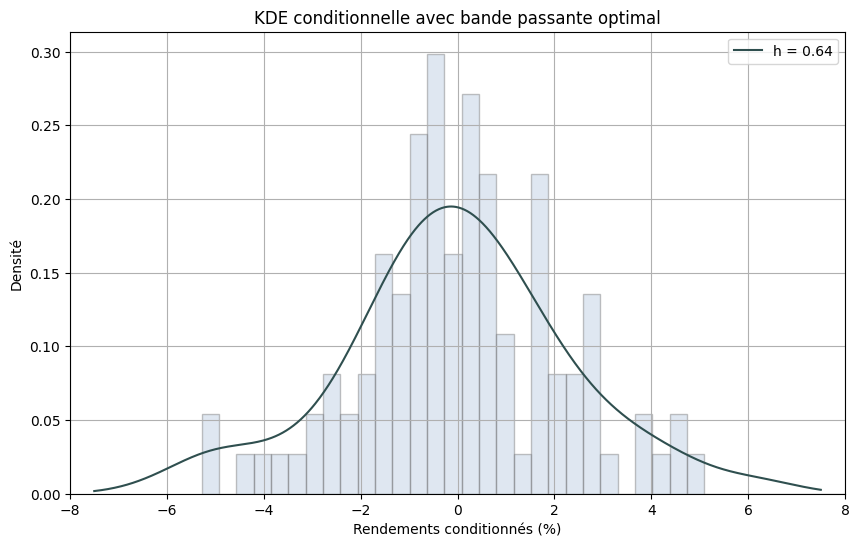

In [36]:
import matplotlib.pyplot as plt
import numpy as np


conditioned_returns = clean_returns[::horizon]
x_grid = np.linspace(-7.5, 7.5, 1000)


density_values = np.array([conditional_density_function(x, x) for x in x_grid])

label = f"h = {optimal_bandwidth:.2f}"


plt.figure(figsize=(10, 6))
plt.hist(conditioned_returns, bins=40, density=True, edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')
plt.plot(x_grid, density_values, color='darkslategray', label=label)
plt.xlabel('Rendements conditionnés (%)')
plt.ylabel('Densité')
plt.legend()
plt.xlim(-8, 8)
plt.grid(True)
plt.title("KDE conditionnelle avec bande passante optimal")
plt.show()


<ipython-input-28-c3e95c35afec>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = conditional_density_func(x, x)


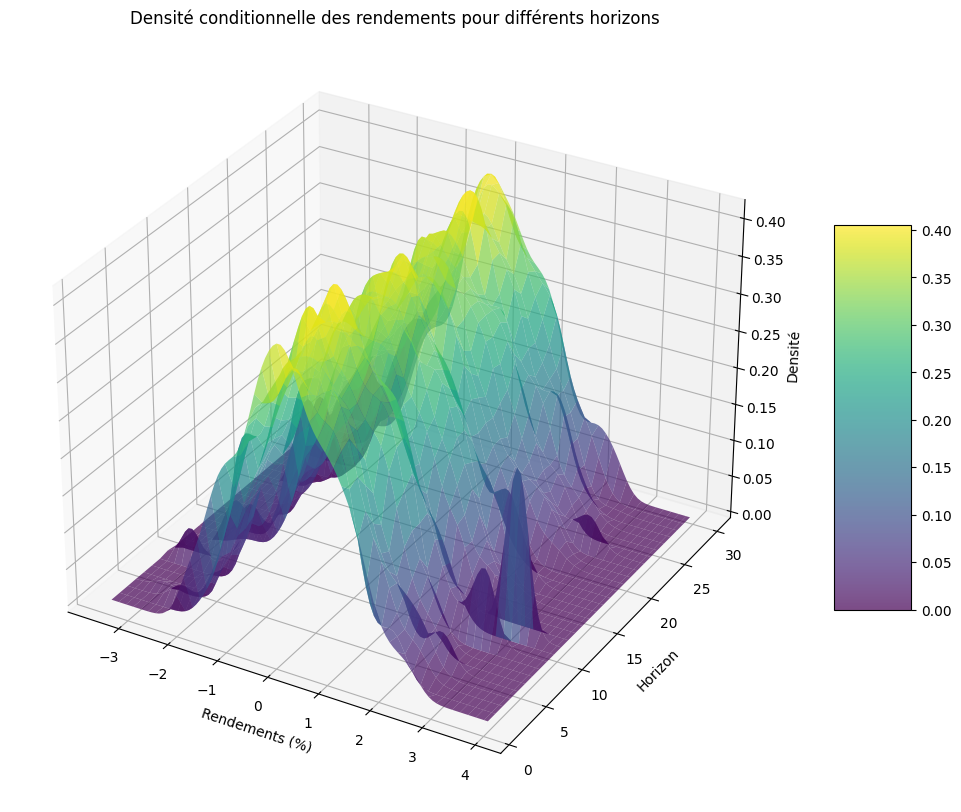

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


horizons = np.arange(1, 31)


X, Y = np.meshgrid(np.linspace(np.min(clean_returns), np.max(clean_returns), 100), horizons)
Z = np.zeros(X.shape)

# Calcul de la densité conditionnelle pour chaque horizon et chaque point dans la grille X
for i, horizon in enumerate(horizons):
    conditional_density_func, _ = estimate_conditional_density(clean_returns, horizon)
    # Pour chaque horizon, calculez la densité pour chaque point x dans X
    for j, x in enumerate(X[0, :]):
        Z[i, j] = conditional_density_func(x, x)


fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.7)


fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Rendements (%)')
ax.set_ylabel('Horizon')
ax.set_zlabel('Densité')
ax.set_title('Densité conditionnelle des rendements pour différents horizons')
plt.show()
